In [1]:
import importlib
import math
import time

import numpy as np
import pandas as pd

import skimage
from skimage.io import imread
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d
from torch.optim import Adam
from torch.utils import data

import albumentations as albu

import natural_images_dataset_loader
from natural_images_dataset_loader import get_dataset_info, get_files_label_map, make_loaders

In [2]:
importlib.reload(natural_images_dataset_loader)
from natural_images_dataset_loader import get_dataset_info, get_files_label_map, make_loaders

In [3]:
%matplotlib inline

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
class NaturalImagesNet(nn.Module):
    
    def __init__(self, in_channels, classes_num):
        super(NaturalImagesNet, self).__init__()
        self.in_channels = in_channels
        self.conv0 = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=0)
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=2 * in_channels, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(in_channels=2 * in_channels, out_channels=in_channels, kernel_size=5, stride=1, padding=0)
        self.relu0 = ReLU()
        #self.fc2 = Linear(120 * 120 * in_channels, classes_num)
        #self.fc3 = Linear(126 * 126 * in_channels, classes_num) - for minimal net with relu - conv0, relu, fc3
        self.fc3 = Linear(120 * 120 * in_channels, classes_num)
        ####### Input img size 64x64
        #self.fc_out = Linear(62 * 62 * in_channels, classes_num)
        #self.fc0 = Linear(2 * 60 * 60 * in_channels, classes_num)
        #self.fc1 = Linear(56 * 56 * in_channels, classes_num)
        ######################
        
    def forward(self, x):        
        #print("forward: x.shape before conv0(x)", x.shape)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        #print("x.shape: ", x.shape)
        x = self.relu0(x)
        #print("forward: x.shape after conv0(x)", x.shape)
        #x = x.view(-1, 62 * 62 * self.in_channels)
        #x = x.view(-1, 2 * 62 * 62 * self.in_channels)
        
        x = self.conv2(x)
        #print("x.shape after self.conv2(x): ", x.shape)
        x = self.relu0(x)
        
        #x = x.view(-1, 2 * 60 * 60 * self.in_channels)        
        #x = self.fc0(x)
        
        #x = x.view(-1, 56 * 56 * self.in_channels)
        #x = self.fc1(x)
        
        #x = x.view(-1, 120 * 120 * self.in_channels)
        #x = self.fc2(x)
        
        #x = x.view(-1, 126 * 126 * self.in_channels)
        #x = self.fc3(x)
 
        x = x.view(-1, 120 * 120 * self.in_channels)
        x = self.fc3(x)
        #x = F.log_softmax(x, dim=1)
        #x = F.log_softmax(x)
        #x = self.fc_out(x)
        #print("forward, x after log_softmax:\n", x)
        return x

params = {'batch_size': 4, 'shuffle': True}
class_label_map = get_class_label_map('../input/natural-images/natural_images/*')

ni_ds_train = NaturalImagesDataset(class_label_map, resize_sizes=(64, 64))
ni_train_dataloader = data.DataLoader(ni_ds_train, **params)

ni_ds_valid = NaturalImagesDataset(class_label_map, valid=True, resize_sizes=(64, 64))
ni_valid_loader = data.DataLoader(ni_ds_valid, **params)

In [6]:
dataset_info = get_dataset_info('../input/natural-images/natural_images/*')
#print("len(dataset_info):", len(dataset_info))
#print("type(dataset_info[0][2]): ", type(dataset_info[0][2]))
#print("dataset_info[0][2][:10]: ", dataset_info[0][2][:10])
files_label_map = get_files_label_map(dataset_info)
#print(get_files_label_map(dataset_info)[2000:2020])
#print(type(make_loaders(files_label_map)))
train_dl, valid_dl, test_dl, fl_maps = make_loaders(
    files_label_map,
    train_test_split_ratio=0.25,
    train_valid_split_ratio=0.25,
    img_resize_sizes=(128, 128),
    transforms=(albu.Compose([albu.RandomRotate90()]), None, None),
    #transforms=(albu.RandomRotate90(), None, None),
    #transforms=(None, None, None)
)
#print(type(train_dl), type(valid_dl), type(test_dl))

In [7]:
classes_num = len(dataset_info)
print(classes_num)

8


In [8]:
input_channels = 3

In [9]:
learning_rate = 0.0001
#learning_rate = 0.001

In [10]:
#img, label = next(iter(ni_train_dataloader))
img, label = next(iter(train_dl))

In [11]:
type(img)
print(img.shape)

torch.Size([4, 3, 128, 128])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
print("device: ", device)

device:  cuda:0


In [14]:
model = NaturalImagesNet(input_channels, classes_num)
#model = NaturalImagesNet()

In [15]:
model.to(device)

NaturalImagesNet(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu0): ReLU()
  (fc3): Linear(in_features=43200, out_features=8, bias=True)
)

In [16]:
loss_function = CrossEntropyLoss()

In [17]:
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
#num_of_epoch = 20
#num_of_epoch = 120
#num_of_epoch = 60
num_of_epoch = 16

train_losses = []
val_losses = []

start_time = time.time()

epoch_train_losses = []
epoch_val_losses = []

for epoch in range(num_of_epoch):
    # loop over the dataset multiple times
    
    avg_train_cost = 0
    avg_val_cost = 0
    
    train_running_loss = 0.0
    val_running_loss = 0.0
    
    one_epoch_train_losses = []
    one_epoch_val_losses = []
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        
        train_losses.append(loss)
        
        one_epoch_train_losses.append(loss)
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print("epoch: {}, batch: {} train running loss: {}".format(epoch, i, train_running_loss / 20))
            train_running_loss = 0.0
            
        avg_train_cost = avg_train_cost + loss.data
                
    if epoch % 2 != 0:
        print("epoch {}, avg train cost: {}".format(epoch, avg_train_cost))
        avg_train_cost = 0
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
                
            outputs = model(inputs)
                
            val_loss = loss_function(outputs, labels)
            val_losses.append(val_loss)
            one_epoch_val_losses.append(val_loss)
            val_running_loss += val_loss.item()
                
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print("epoch: {}, batch: {} val running loss: {}".format(epoch, i, val_running_loss / 20))
                val_running_loss = 0.0
                
        avg_val_cost = avg_val_cost + loss.data
                
        if epoch % 2 != 0:
            print("epoch {}, avg val cost: {}".format(epoch, avg_val_cost))
            avg_val_cost = 0

    epoch_train_losses.append(one_epoch_train_losses)
    epoch_val_losses.append(one_epoch_val_losses)

    
avg_epoch_train_losses = [
    sum(one_epoch_train_loss) / len(one_epoch_train_loss) for one_epoch_train_loss in epoch_train_losses
]
avg_epoch_val_losses = [
    sum(one_epoch_val_loss) / len(one_epoch_val_loss) for one_epoch_val_loss in epoch_val_losses
]

print('Finished Training')
time_elapsed = time.time() - start_time
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

In [21]:
def train(model, device, data_loader, optimizer, loss_function, epoch):
    
    total_loss = 0
    losses = []

    for i, data in enumerate(data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)       
        losses.append(loss)        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / (i + 1)
    
    return avg_loss, losses    

In [25]:
def test(model, device, data_loader, loss_function, epoch):
    model.eval()
    
    losses = []
    total_loss = 0
    predicted_correct = 0
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
                
            outputs = model(inputs)
                
            loss = loss_function(outputs, labels)
            total_loss += loss
            losses.append(loss)
            
            _, predicted = torch.max(outputs.data, 1)
            predicted_correct += torch.sum(predicted == labels).item()
            
    avg_loss = total_loss / (i + 1)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss,
        predicted_correct,
        len(data_loader.dataset),
        100. * predicted_correct / len(data_loader.dataset)
    ))
    
    return avg_loss, losses

In [27]:
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print("Training on", device)
start_time = time.time()
for epoch in range(1, epochs + 1):
        train_loss, _ = train(model, device, train_dl, optimizer, loss_function, epoch)
        valid_loss, _ = test(model, device, valid_dl, loss_function, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        
print('Finished Training')
time_elapsed = time.time() - start_time
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

Training on cuda:0
Validation set: Average loss: 0.677117, Accuracy: 1003/1293 (78%)

Validation set: Average loss: 0.678854, Accuracy: 975/1293 (75%)

Validation set: Average loss: 0.740432, Accuracy: 946/1293 (73%)

Validation set: Average loss: 0.648238, Accuracy: 994/1293 (77%)

Validation set: Average loss: 0.656893, Accuracy: 989/1293 (76%)

Validation set: Average loss: 0.896045, Accuracy: 918/1293 (71%)

Validation set: Average loss: 0.704166, Accuracy: 963/1293 (74%)

Validation set: Average loss: 0.626163, Accuracy: 1007/1293 (78%)

Validation set: Average loss: 0.649150, Accuracy: 994/1293 (77%)

Validation set: Average loss: 0.718066, Accuracy: 986/1293 (76%)

Finished Training
Training complete in 10m 4s


In [ ]:
#plt.figure(figsize=(18, 18))
#plt.plot(avg_epoch_train_losses, label="avg epoch training loss")
#plt.plot(avg_epoch_val_losses, label="avg epoch validation loss")
#plt.legend()
#plt.show()

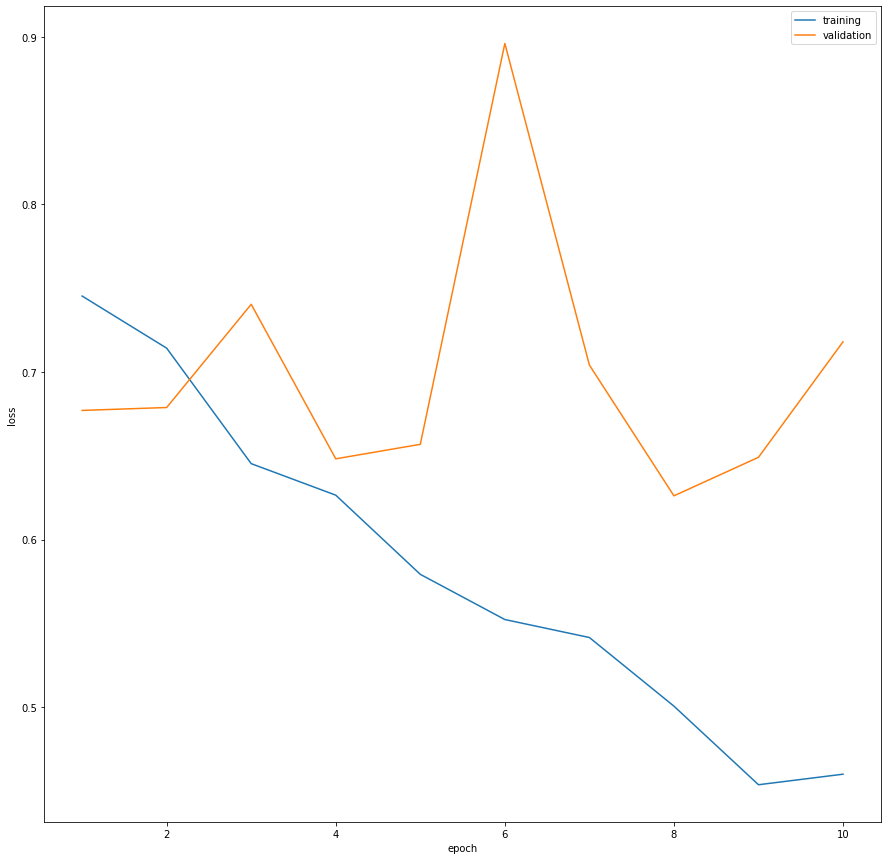

In [28]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
#x, y = Variable(train_x), Variable(train_y, requires_grad=False)

#pred = model(x)

#final_pred = np.argmax(pred.data.numpy(), axis=1)

#accuracy_score(train_y, final_pred)

In [ ]:
#PATH = './my_first_model_1_with_1_conv_layers_1_fc_lapyer_maximal_smple.pth'
#torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(valid_dl)
images, labels = dataiter.next()

In [ ]:
#print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % class_label_map[labels[j]] for j in range(4)))

In [ ]:
#model0 = NaturalImagesNet()
#model0.load_state_dict(torch.load(PATH))

In [ ]:
images = images.to(device, dtype=torch.float32)

In [ ]:
#outputs = model0(images)
outputs = model(images)

In [ ]:
#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % class_label_map[predicted[j]]
#                              for j in range(4)))

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images.to(device, dtype=torch.float32))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))

Accuracy of the network on the test images: 73 %


In [ ]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        labels = labels.to(device)learning_rate = 0.00001
        outputs = model(images.to(device, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        #for i in range(4):
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        dataset_info[i][0], 100 * class_correct[i] / class_total[i]))

In [ ]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()